### Introduction: Applying Computational Thinking to Personal Finance and Portfolio Analysis
In an era where financial independence is closely tied to the ability to make strategic investment decisions, understanding the mechanics of saving and investing has become a critical life skill. Yet, while many individuals understand the importance of saving, few have the tools or knowledge required to evaluate how different financial strategies—and especially investment decisions—impact long-term outcomes. This tutorial addresses that gap by introducing students to essential concepts in personal finance and portfolio analysis through a computational and data-driven approach.

This tutorial begins by building a foundation in core savings principles. Learners will explore the functionality of common financial instruments such as high-yield savings accounts, 401(k)s, and Roth IRAs. Through interactive inputs and simulations, students will see how interest rates, compound growth, and tax advantages affect returns over time. These early exercises aim to demonstrate the value of starting early, contributing consistently, and choosing the right savings vehicles for one’s personal financial goals.

Building on this foundation, the tutorial then transitions into a more advanced, investment-focused module: constructing and evaluating a personalized stock portfolio. Students will be guided through the process of:
- Selecting their own breakdown of stocks to form a diversified portfolio based on individual risk preferences or interests.

- Evaluating the strength of their chosen portfolio using historical data and key financial metrics.

- Simulating potential future outcomes through Monte Carlo simulations, which model thousands of possible future scenarios to account for uncertainty and market volatility.

- Optimizing the stock allocation using algorithmic methods that balance return potential with risk, aiming for the most efficient use of investment capital.

- Rechecking the portfolio’s strength after optimization, to reflect the improvements made and demonstrate the impact of computational adjustments on financial performance.


Throughout this tutorial, students will employ principles from computer science—such as data modeling, simulations, algorithmic thinking, and data visualization—to analyze financial data and make informed decisions. By the end of the tutorial, students will have developed not only a deeper understanding of financial literacy but also a practical appreciation for how computational tools can empower individuals to manage their personal wealth more effectively.

This interdisciplinary exploration is designed to equip learners with a strong foundation in both personal finance and applied computation—skills that are increasingly essential in today’s data-rich, financially complex world.

### Disclaimer

**No Guarantee of Accuracy:** While Isabel, Luna, and Nirantheri strive to provide accurate and up-to-date information, they do not guarantee the accuracy, completeness, or reliability of any content. Users should independently verify any information before making financial or investment decisions based on it.


**Investment Risks:** Investing involves inherent risks, including but not limited to market fluctuations, economic uncertainty, geopolitical events, and individual asset performance. Past performance is not indicative of future results, and no content provided implies a guarantee of investment success.

**Limitation of Liability:** Mentions of specific financial products, services, companies, or securities within the content do not constitute endorsements or recommendations. Users are responsible for conducting their own research and due diligence.

**No Liability:** Isabel, Luna, Nirantheri, and their affiliates, partners, or contributors shall not be held liable for any loss, damage, or expense resulting from the use of or reliance on the provided information. All investment decisions made based on this content are the sole responsibility of the user.

**Disclaimer Updates:** This disclaimer is subject to change without notice. Users are responsible for reviewing it periodically to stay informed of any updates.



### This is where you'll download all packages necessary for the tutorial

If the "Module not found" error shows up, use the requirements.txt file to download the missing packages.

In [88]:
#reordering
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

#alphabetical 
import yfinance as yf
import numpy as np
import ipywidgets as widgets
import pandas as pd
from scipy.optimize import minimize
import altair as alt
# from pandas_datareader import data as wb
import seaborn as sns
from scipy.stats import norm
import quantstats.stats as stats



### Choosing stocks for a portfolio

Ctrl+ Click your stocks

In [89]:
codes = {"Apple": 'AAPL',
        "Costco": 'COST',
        "Microsoft": 'MSFT',
        "Google": 'GOOG',
        "Nvidia": 'NVDA',
        "Walmart": 'WMT',
        "AMC Entertainment": 'AMC',
        "S&P 500": '^GSPC',
        "Dow Jones Industrial": '^DJI',
        "Nasdaq": '^IXIC',
        "Vanguard S&P 500 ETF": 'VOO',
        "Fidelity 500 Index Fund": 'FXAIX',
        "Gold":'GLD'}

codes.keys()


choices = widgets.SelectMultiple(
    options=codes.keys(),
    value=[],
    rows=20,
    description='Stocks',
    disabled=False
)

display(choices)

SelectMultiple(description='Stocks', options=('Apple', 'Costco', 'Microsoft', 'Google', 'Nvidia', 'Walmart', '…

### Picking your own breakdown of stocks : Nirantheri

<!-- clarifying what the breakdown of stocks is, why are we doing this -->

Without rerunning the previous code chunk, run the next one and input your allocation amounts as a decimal ex (0.3 or .5). Make sure they add up to 1!
<!--
[setup using the above code chunk](https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#Tabs) -->

In [90]:
# get codes for further down
portfolio = []

for i in range(len(choices.value)):
    portfolio.append(codes[choices.value[i]])
    
# pick distribution

tab_contents = ["Value"] * len(choices.value)
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = choices.value

tab

Tab()

The following code is to match the allocation amounts to the stock codes given the inputs from above. 

In [91]:
# matching allocation amounts to stock codes given inputs from above

allocations = {}

for i in range(len(tab.children)):
    allocations[portfolio[i]]=tab.children[i].value


### Interested in testing out your own set of stocks?

Feel free to create your own allocation dictionary. Make sure each entry is of the format "STOCK TICKER": allocation amount. Fill it in as you desire and click run to make sure that your custom allocations are used, even if you didn't run the above lines. Otherwise our default set of stocks will be used! 

NOTE: for index funds, you have to prefix them with "^"

In [92]:
# Here's an example of what your dictionary can look like

# {'AAPL':'0.4', 'MSFT':'0.3',  '^IXIC':'0.3'}

allocations = {}

### Pulling the yf data

Using the list of stocks in our dictionary, the below code will grab the data for each stock.

In [93]:
if len(portfolio)==0: # for default values
    allocations={'AAPL':'0.2', 'MSFT':'0.2',  '^IXIC':'0.1', 'NVDA': '0.1', 'WMT': '0.1', 'AMC':'0.1', '^GSPC':'0.1'}
    portfolio = list(allocations.keys())

testList=list(allocations.keys())
testString = ' '.join(testList)

tickersPull = yf.Tickers(testString)

#in the dictionary dataframes, each ticker is indexed by its ticker as seen in the testList (auto_adjust accounts for splits and dividends)
dataframes = {}
for x in testList:
    ticker = yf.Ticker(x)
    dataframes[x] = ticker.history(period='1mo', start='2015-01-01', auto_adjust=True)

### How do we calculate returns?

<!-- have we defined returns at this point? -->

To calculate the returns, we want to find the adjusted value of each stock amount from the date of the initial investment. We can write a function to do this with a set of inputs-- an initial portfolio value, the set of dataframes for each stock, and the breakdown of allocations  <!-- and perhaps even an initial date of investment.  -->

In [94]:
def calculate_returns(initial_portfolio_val, dataframe, allocations):
    all_pos_vals = []

    for stock_name in dataframe:
        # grab the dataframe for a single stock
        stock_df = dataframe[stock_name] 
        # create normed return column
        stock_df['Normed Return'] = stock_df['Close'] /stock_df.iloc[0]['Close']

        # use normed return to adjust the percentage of portfolio held
        allocation = float(allocations[stock_name])  # Convert allocation to float
        stock_df['Allocation'] = stock_df['Normed Return']*allocation

        # find value of stock at each date
        stock_df['Position Value'] = stock_df['Allocation']*initial_portfolio_val

        # add to list of all position values
        all_pos_vals.append(stock_df['Position Value'])

    # concatenate the list of position values
    portfolio_val = pd.concat(all_pos_vals, axis=1)

    # set the column names
    portfolio_val.columns = portfolio

    # add a total portfolio column
    portfolio_val['Total'] = portfolio_val.sum(axis=1)

    # changing date to column not index
    portfolio_val = portfolio_val.reset_index()
    
    return portfolio_val



Then we can create a graphical representation of each of the stocks' growths over time as well as the portfolio's overall growth. To get an overall number rather than using every single data point, we can use a resampling function to grab the last day of each month in the data.

In [95]:
def graph_values(portfolio_values, graph_portfolio=False, graph_stocks=False):
    """graph_portfolio is a bool to show only the total portfolio, graph_stocks is to graph all stocks."""

    # Resample the portfolio_val DataFrame to only include the last date of each month
    portfolio_val = portfolio_values.resample('ME', on='Date').last().reset_index()

    if graph_portfolio:
        portfolio_val['Total'].plot(figsize=(10,8))
    if graph_stocks:
        portfolio_val.drop('Total', axis=1).set_index('Date').plot(figsize=(10,8)) 


    print("total value", portfolio_val['Total'].iat[-1])


Now that we've created a projection of how our data has been growing over time, let's see what to expect!

total value 26718280.44657275


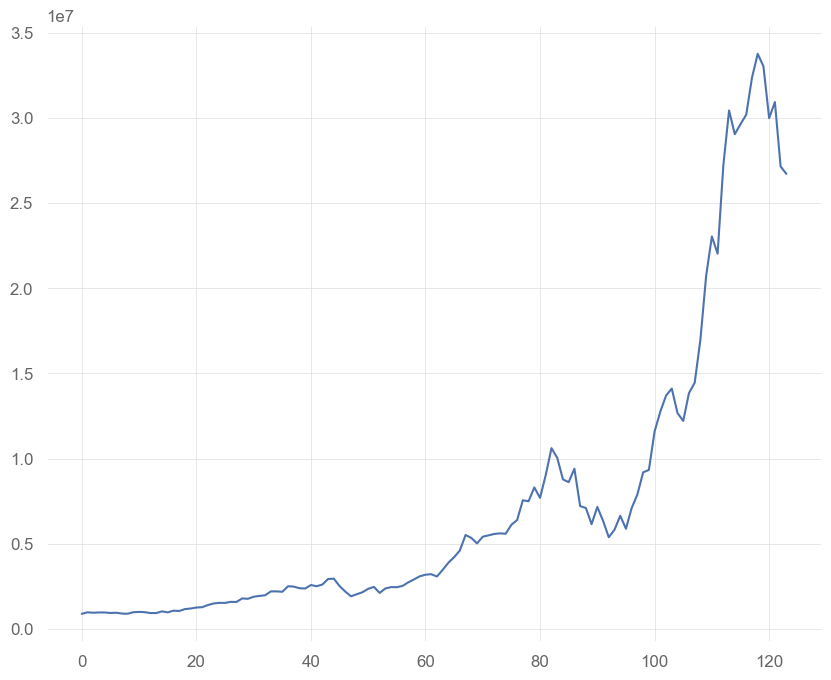

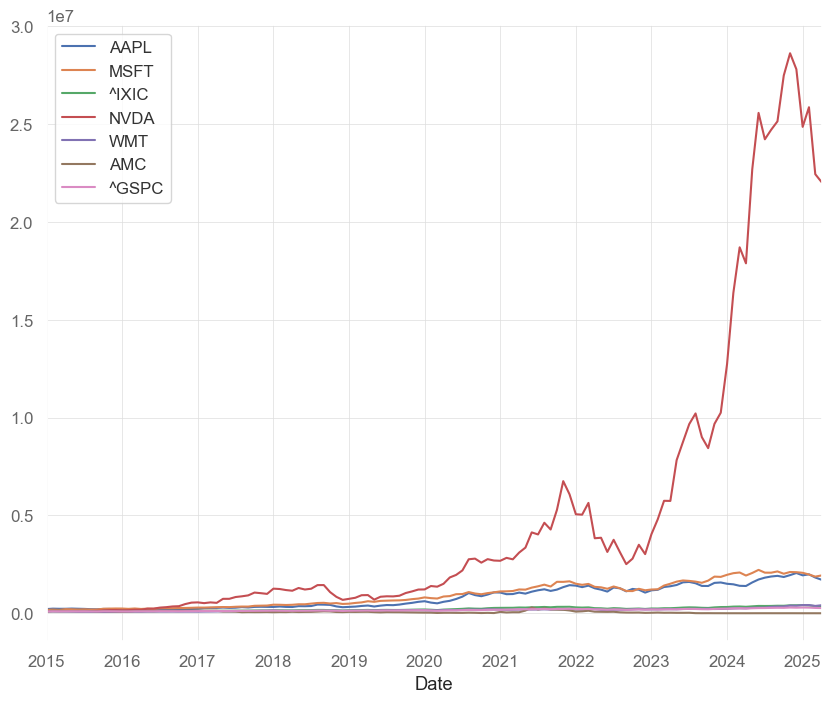

In [96]:
returns = calculate_returns(1e6, dataframes, allocations)

graph_values(returns, True, True)

In [97]:
# TODO: Implement the altair version which has more interactivity

# # need to pivot the data
# # print(portfolio_val.head())
# print(portfolio_val.info())
# portfolio_val.drop("^IXIC", axis=1)
# pivoted_data = portfolio_val.melt(id_vars="Date", var_name="Stock", value_name="Value")

# pivoted_data.head()


# alt.Chart(pivoted_data).mark_line().encode(
#     alt.X("Date:T", title="Date"),
#     alt.Y("Value:Q", title="Portfolio Value"),
#     alt.Color("Stock:N", title="Stock")
# )


# plot our portfolio

## 🧾 Portfolio Strength Breakdown
**How do you know if your portfolio is actually working?**

####TODO expected_return,

Think of your portfolio like a car — you wouldn’t drive it for miles without checking the engine, right? These metrics are your dashboard. They tell you whether you're cruising efficiently, burning too much fuel (aka risk), or heading toward a cliff. By regularly checking them, you’re not just investing — you’re investing intelligently. It's how you turn guessing into strategy.

These metrics help you assess whether your portfolio is efficient, risky, or well-balanced — and give you data to improve it over time. We can write a function to return these values for us.

In [98]:
def portfolio_stats(returns):
    # Ensure datetime is clean
    returns.set_index('Date', inplace=True)

    # Daily returns from portfolio value
    daily_returns = returns['Total'].pct_change().dropna()

    # Grab specific stats
    cagr = stats.cagr(daily_returns)
    sharpe = stats.sharpe(daily_returns)
    drawdown = stats.max_drawdown(daily_returns)
    volatility = stats.volatility(daily_returns)
    avg_return = stats.avg_return(daily_returns)

    return {"cagr":cagr, "sharpe":sharpe, "drawdown":drawdown, "volatility":volatility, "avg_return":avg_return}


Now that we've written a function for this, we can analyze the returns of our portfolio from above.

In [99]:
portfolio_info = portfolio_stats(returns)

#### Now let's analyze these metrics!

**📈 CAGR (Compound Annual Growth Rate)**
This shows the average annual growth of your portfolio over time. The higher, the better — it reflects long-term performance. A higher CAGR generally reflects strong long-term performance. For context, a CAGR of 7–10% is typically considered solid, especially when compared to market benchmarks like the S&P 500.

In [100]:
print(f"📈 CAGR (Annual Return): {portfolio_info['cagr']:.2%}")

📈 CAGR (Annual Return): 25.51%


**📊 Sharpe Ratio:**  
Measures your return per unit of risk. A Sharpe ratio above 1.0 is generally considered good. It means you're getting rewarded well for the volatility you’re taking on. A value above 1.0 suggests you're earning a good return for the amount of risk taken, while a ratio above 2.0 is considered excellent. Anything below 1.0 may indicate that returns aren’t efficiently compensating for risk.

In [101]:
print(f"📊 Sharpe Ratio: {portfolio_info['sharpe']:.2f}")

📊 Sharpe Ratio: 1.12


**📉 Max Drawdown:**  
The worst loss your portfolio experienced from peak to bottom. Lower drawdowns are better, as they reflect greater stability and less severe losses. A drawdown under 20% is generally seen as moderate, while anything over 30% may signal high risk or poor diversification.

In [102]:
print(f"📉 Max Drawdown: {portfolio_info['drawdown']:.2%}")

📉 Max Drawdown: -52.06%


**📈 Volatility:**  
Reflects how much your portfolio's value fluctuates. High volatility can mean high risk — or high opportunity. Higher volatility can mean bigger gains — but also bigger losses. For comparison, broad market indices tend to have volatility in the 15–20% range; values much higher than that could mean the portfolio is more aggressive or unstable.

In [103]:
print(f"📈 Volatility: {portfolio_info['volatility']:.2%}")

📈 Volatility: 34.92%


**📅 Average Daily Return:**  
The average return your portfolio gained (or lost) per trading day. Helps you see how it behaves short term. This captures how much the portfolio gains or loses on an average trading day. While daily gains may appear small in percentage terms, even modest positive averages can lead to significant annual growth through compounding.

In [104]:
print(f"📅 Average Daily Return: {portfolio_info['avg_return']:.2%}")

📅 Average Daily Return: 0.16%


### Now we'll run a monte carlo simulation to try to estimate the predicted value of the stocks in future.

In [105]:
df = pd.DataFrame()
ticker = yf.Ticker("GOOG")
df['GOOG'] = ticker.history(interval = '1d', start = '2015-01-01')['Close']

log_return = np.log(1 + df.pct_change().dropna())

# print(log_return)

# sns.displot(log_return)
# plt.xlabel("Daily Return")
# plt.ylabel("Frequency")

u = log_return.mean()
var = log_return.var()
drift = u - (.5*var)

stdev = log_return.std()
days = 50
trials = 10000
Z = norm.ppf(np.random.rand(days, trials))
daily_return = np.exp(drift.values + stdev.values * Z)

price_paths = np.zeros_like(daily_return)
price_paths[0] = df.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_return[t]

# print(price_paths)

In [106]:
def import_stock_data(tickers, start = "2015-01-01"):
    data = pd.DataFrame()
    if len(tickers) == 1:
        stock = yf.Ticker(tickers[0])
        data[tickers[0]] = stock.history(interval = '1d', start = start)['Close']
    else:
        for x in tickers:
            stock = yf.Ticker(x)
            data[x] = stock.history(interval = '1d', start = start)['Close']
    return data

def log_returns(data): 
    return np.log(1 + data.pct_change().dropna())

def simple_returns(data):
    return (data/(data.shift(1))-1)

def market_data_combination(data, mark_ticker='^GSPC', start = '2015-01-01'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data)
    ann_return = np.exp(market_rets.mean() * 252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

def drift_calc(data, return_type = "log"): 
    if return_type == "log":
        lr = log_returns(data)
    elif return_type == "simple":
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(.5*var)
    try: 
        return drift.values
    except:
        return drift

def daily_returns(data, days, iterations):
    ft = drift_calc(data)
    try: 
        stv = log_returns(data).std().values
    except:
        stv = log_returns(data).std()

    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr

def simulate_mc(data, days, iterations, return_type='log', plot=True):
    returns = daily_returns(data, days, iterations)
    price_list = np.zeros_like(returns)
    price_list[0] = data.iloc[-1]
    for t in range(1, days):
        price_list[t] = price_list[t-1] * returns[t]
    
    # if plot:
    #     x = pd.DataFrame(price_list).iloc[-1]
    #     fig, ax = plt.subplots(1,2, figsize=(14,4))
    #     sns.displot(x, ax=ax[0])
    #     sns.displot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True}, ax=ax[1])
    #     plt.xlabel('Stock Price')
    #     plt.show()
    

    total_days = days - 1
    expected_value = round(pd.DataFrame(price_list).iloc[-1].mean(), 2)
    return_pct = round(100*(expected_value-price_list[0,1])/expected_value, 2)

    return [total_days, expected_value, return_pct]

def monte_carlo(ticker, days, iterations):
    df = import_stock_data([ticker])
    return simulate_mc(df, days, iterations)

print(monte_carlo('GOOG', 10, 100))

[9, 161.88, 0.25]


The output of this is in the order (total_days, expected value, return percentage)

#####TODO rewrite

## Optimizing the stock portfolio

It's great that we can create a stock portfolio that we can work with, and we can even analyze how strong it is using quantstats! It would be even better if we could take the portfolio we made and see if we can change our investment amounts to maximize our returns. There are a couple steps to get it set up, but thankfully, scipy has a function that can maximize our returns given an initial investment percentage for each stock, and a history of each stock's percentage change in price.

First, we are going to create a sample version of our portfolio that pulls stock history for every ticker that we have selected, adding their opening price at every interval to the function and storing all of this in a dataframe. Then, we use the pct_change function to determine the change between each frame for each stock, allowing us to determine the most efficient investment of stocks.

In [107]:
testList = portfolio

# pull the first stock's data; drop all unnecessary columns
ticker = yf.Ticker(testList[0])
df = ticker.history(interval = '1d', start = '2015-01-01', end = '2025-04-01')
df.drop(columns=['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], inplace=True)
df.rename({'Open' : 'AAPL'}, inplace=True)

# for every other ticker, add its open value to the existing dataframe
for x in testList[1:]:
    ticker = yf.Ticker(x)
    data = ticker.history(interval = '1d', start = '2015-01-01', end = '2025-04-01')
    df.insert(len(df.columns), x, data["Open"]) # for whatever reason, this line wont work

#calculate percent returns for each day of each stock
returns_df = df.pct_change(1).dropna()

Now, we need to determine the value of each portfolio's return. This is simply the return of each stock multipled by its weight in the portfolio. Because it is this way for each stock, we can compute the return as a dot product of returns and weights, then multiply by 250 trading days in a year to annualize our result!

In [108]:
#operationalize determining portfolio returns
def getPfReturn(weights):
    """
    return is annualized expected return of portfolio
    """
    expRetPortfolio = np.dot(np.transpose(weights), returns_df.mean()) * 250
    return expRetPortfolio

Now, we need to start bounding the function that will maximize our returns given an investment. We will use scipy's minimize function to do this. Despite its name, the minimize function works by minimizing the constraints that you give it, so minimizing the difference between our portfolio return and our target return will enable us to hit our target return, "maximizing" the output of our portfolio. If we want to truly maximize, we can continue pushing up this target return incrementally until we reach it!.

First, we will start with initial weights of each stock in our portfolio. We can either use the weights we selected previously, or we can simply start with each stock having an equal weight in our portfolio. You can choose this by slightly modifying the code below. ###need to add this modification

Now, we need to set our target return value, which we selefcted to arbitrarily be .4, or a 40% return. This can be modified however you wish, but do note that the minimize function will fail if maximizing to the given return percentage is impossible.

Another important goal is to bound the weight of each stock in our portfolio between 0 and 1, or 0% and 100%. It doesn't make much sense to be able to buy more than a full portfolio of stocks! We do this by creating a tuple that has the same length as our number of stocks, and each element in the tuple is another tuple storing the values (0,1), bounding our stock weights in that range

Finally, we want to create two constraints for the function. This is done using the syntax below. Our first constraint says tat the sum of all weights should not exceed 1, or that our portfolio weights can't exceed 100%. We've done this already for individual stocks, but it's also important that we cant just spend 100% of our money in each stock. Finally, we also need to make sure that we "minimize" the difference between the returns for any set of portfolio weights the function generates and the target return we have set. 

In [109]:
# start with stocks at equal weights
numStocks = len(returns_df.columns)
initialWeight = [1/numStocks] * numStocks

# Feel free to pick a different number!
targetReturn = .4

# bounds the percentage of each stock we can hold (between 0 and 100%)
bounds = tuple((0,1) for i in range(numStocks))

# ensures the sum of all stock weights is 100% (or 1) in first constraint
# sets goal of minimize function to hit targetReturn
constraints = ({'type' : 'eq', 'fun' : lambda w : np.sum(w) - 1},
               {'type' : 'eq', 'fun' : lambda x : x.dot(returns_df.mean()) * 250 - targetReturn})


Now that we have set all of our constraints, we need to use the maximize function! We set a variable called "results" equal to the minimize function with our function and all of the constraints. Through magic of scipy, it will iterate on our weights, modifying them in an attempt to maximize the return of our portfolio. We can print results to see whether it was successful, as well as the weights of each stock in our portfolio. We can also see our returns by using our returns function on the 'x' field of our minimize output.

In [114]:
# can we reach our goal with these stocks??
results = minimize(fun=getPfReturn, x0=initialWeight, bounds=bounds, constraints=constraints)

#output
print(results)

optimizedResults = pd.DataFrame(results['x'])

# print our optimized results
getPfReturn(weights=results["x"])
optimizedResults.index = returns_df.columns
print(optimizedResults)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.4000000002833497
       x: [ 1.290e-01  1.270e-01  6.719e-02  3.539e-01  6.781e-02
            2.100e-01  4.504e-02]
     nit: 2
     jac: [ 2.536e-01  2.501e-01  1.462e-01  6.443e-01  1.472e-01
            3.944e-01  1.077e-01]
    nfev: 16
    njev: 2
              0
Open   0.129024
MSFT   0.127013
^IXIC  0.067194
NVDA   0.353889
WMT    0.067807
AMC    0.210037
^GSPC  0.045036


Now, we've successfully used scipy to maximize the results from our function! We can even extract the weights and use them to model a portfolio. Let's use some similar code to graph the returns of a portfolio based on an inital investment above, but using our new optimized weights!

total value 80942200.52301426


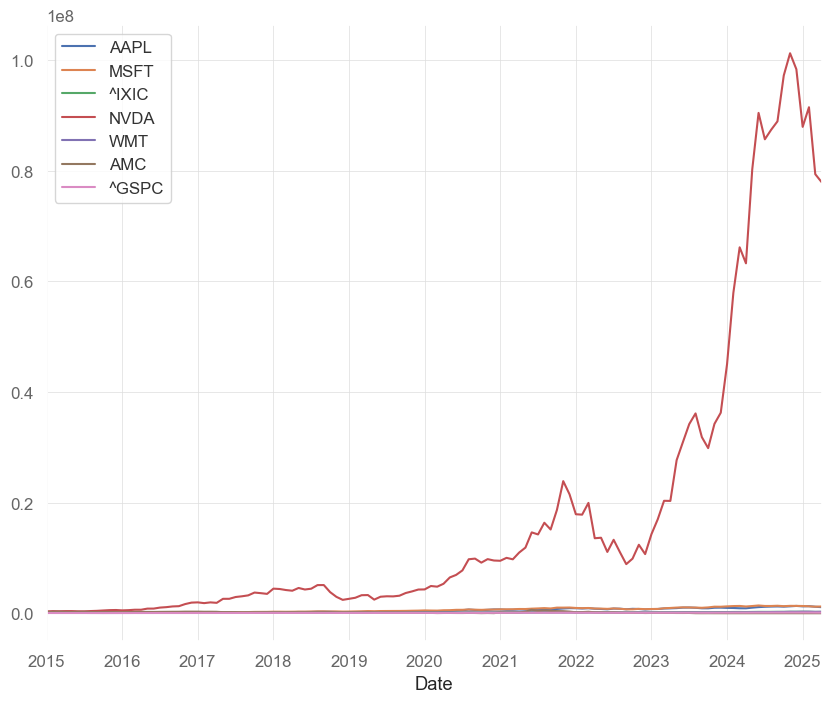

In [115]:
initial_portfolio_val = 1e6

optimizedResults.rename(index={optimizedResults.index[0]: portfolio[0]}, inplace=True)
optimized_allocations = optimizedResults[0].to_dict()


optimized_returns = calculate_returns(initial_portfolio_val, dataframes, optimized_allocations)

graph_values(optimized_returns, False, True)

### 📉 Rechecking Strength After Optimization

After optimizing our portfolio allocations to achieve a target return of 40%, we reevaluate the portfolio using updated historical performance metrics.

To review:

- **CAGR (Annual Return):** Shows the expected annual growth based on optimized allocations.
- **Sharpe Ratio:** Tells us how well we’re balancing risk and reward with the new weights.
- **Max Drawdown:** Indicates if the worst-case dip has improved.
- **Volatility:** Helps assess whether the portfolio became more stable or more erratic.
- **Avg Daily Return:** Confirms whether daily trends look stronger after optimization.

This second performance check shows whether our changes actually led to a more efficient investment strategy.

In [116]:
portfolio_info = portfolio_stats(optimized_returns)

print(f"📈 CAGR (Annual Return): {portfolio_info['cagr']:.2%}")
print(f"📊 Sharpe Ratio: {portfolio_info['sharpe']:.2f}")
print(f"📉 Max Drawdown: {portfolio_info['drawdown']:.2%}")
print(f"📈 Volatility: {portfolio_info['volatility']:.2%}")
print(f"📅 Average Daily Return: {portfolio_info['avg_return']:.2%}")

📈 CAGR (Annual Return): 34.23%
📊 Sharpe Ratio: 1.20
📉 Max Drawdown: -62.93%
📈 Volatility: 43.51%
📅 Average Daily Return: 0.21%


### Summary

After constructing our initial stock portfolio based on user-selected allocations, we evaluated its historical performance using metrics like annual return, Sharpe ratio, and drawdown. This gave us a baseline understanding of how well our portfolio performed under those weights.

We then used optimization techniques (via scipy.minimize) to automatically adjust the stock allocations in order to achieve a target return while minimizing risk. This step simulates what a financial algorithm might do to make our portfolio more efficient.

Finally, we re-evaluated the optimized portfolio using the same performance metrics. By comparing the before-and-after results, we can see whether the optimization actually improved our portfolio — either by increasing returns, reducing risk, or improving the Sharpe ratio (risk-adjusted performance).

This comparison demonstrates the power of computational thinking in making data-driven investment decisions.

## Bibliography

https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#Checkbox
https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#SelectMultiple
https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#Tabs


pyfolio: https://www.pyquantnews.com/the-pyquant-newsletter/create-beautiful-strategy-tear-sheets-pyfolio-reloaded


https://medium.com/@ethan.duong1120/python-powered-portfolio-optimization-achieving-target-returns-through-weight-optimization-fc5163e5c9c6